Gevorning equations ([Radko, 2016](https://doi.org/10.1017/jfm.2016.547)):
\begin{align}
    \nabla\cdot \boldsymbol{u} &= 0,\\
    \partial_t \boldsymbol{u} + U_{bg}\partial_x\boldsymbol{u} + w\partial_z U_{bg}\boldsymbol{e}_x + \boldsymbol{u}\cdot\nabla\boldsymbol{u} &= -\nabla p + \frac{Pr}{Pe}\nabla^2\boldsymbol{u} + \frac{4\pi^2 Ri}{R_\rho-1}(T-S)\boldsymbol{e}_z,\\
    \partial_t T + U_{bg}\partial_x T + \boldsymbol{u}\cdot\nabla T - w &= \frac{1}{Pe}\nabla^2 T,\\
    \partial_t S + U_{bg}\partial_x S + \boldsymbol{u}\cdot\nabla S - R_\rho w &= \frac{\tau}{Pe}\nabla^2 S.
\end{align}
where $U_{bg}=sin(2\pi z)$,

For 3D configuration,
\begin{align}
    \nabla\cdot \vec{u} &= 0,\\
    \partial_t u + sin(2\pi z)\partial_x u +2\pi cos(2\pi z)w+ u\cdot\nabla u &= -\partial_x p + \frac{Pr}{Pe}\nabla^2u ,\\
    \partial_t v + sin(2\pi z)\partial_x v + v\cdot\nabla v &= -\partial_y p + \frac{Pr}{Pe}\nabla^2v ,\\
    \partial_t w + sin(2\pi z)\partial_x w + w\cdot\nabla w &= -\partial_z p + \frac{Pr}{Pe}\nabla^2w + \frac{4\pi^2 Ri}{R_\rho-1}(T-S),\\
    \partial_t T + sin(2\pi z)\partial_x T + \vec{u}\cdot\nabla T - w &= \frac{1}{Pe}\nabla^2 T,\\
    \partial_t S + sin(2\pi z)\partial_x S + \vec{u}\cdot\nabla S - R_\rho w &= \frac{\tau}{Pe}\nabla^2 S.
\end{align}

In [220]:
'''
Dedalus script to simulate thermohaline-shear equations in 2D periodic domain.
um, wm, Tm, Sm: <u>, <w>, <T>, <S> (<.> is horizontally averaged variable)
up, wp, Tp, Sp: u', w', T', S'

Parameters: 
Pr (Prandtl), 
tau (diffusivity ratio), 
Rp (R_rho, diffusive density ratio), 
Pe (Peclet)

To run, restart, and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 fluc.py
    $ mpiexec -n 4 python3 fluc.py --restart
'''
import sys
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import math
import h5py
import logging
logger = logging.getLogger(__name__)

# Allow restarting via command line
restart = (len(sys.argv) > 1 and sys.argv[1] == '--restart')

dealias = 3/2 
pi = np.pi
Rp, Ri, Pe, tau = 2., 10., 1e2, 0.01 # figure 4
Pr = 10.  # Prandtl number
Lx, Lz = 64., 1.
Nx, Nz = 384, 192
stop_sim_time = 100 + 300*restart # Stopping criteria
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=np.float64)
# define the coordinate system
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

Now, we decompose perturbations of velocity, pressure, temperature, and salinity fields into two components: mean and fluctuation quantities.
\begin{align}
    \boldsymbol{u} &= \bar{\boldsymbol{u}}+\boldsymbol{u}'\\
    p &= \bar{p}+p',\\
    T &= \bar{T}+T',\\
    S &= \bar{S}+S'.
\end{align}

Based on this, we have horizontally averaged quantities
$$
<\boldsymbol{u}>_h=\bar{\boldsymbol{u}}(z), \quad <\bar{T}>_h=\bar{T}(z), \quad <\bar{S}>_h=\bar{S}(z), \\
<\boldsymbol{u}'>_h=0, \quad <T'>_h=0, \quad <S'>_h=0,
$$
where $<.>_h = \frac{1}{L_x L_y}\int<.>dxdy$

Then, we have
$$
\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{\bar{u}} = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{u}}>_h = <\boldsymbol{u}'>_h\cdot\nabla\boldsymbol{\bar{u}} = 0,\\
<\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{u}'>_h = \boldsymbol{\bar{u}}\cdot\nabla<\boldsymbol{u}'>_h = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{u}'>_h  \neq 0 ,
$$
and 
$$
\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{\bar{T}} = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{T}}>_h = <\boldsymbol{u}'>_h\cdot\nabla\boldsymbol{\bar{T}} = 0,\\
<\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{T}'>_h = \boldsymbol{\bar{u}}\cdot\nabla<\boldsymbol{T}'>_h = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{T}'>_h  \neq 0 ,
$$
and 
$$
\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{\bar{S}} = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{S}}>_h = <\boldsymbol{u}'>_h\cdot\nabla\boldsymbol{\bar{S}} = 0,\\
<\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{S}'>_h = \boldsymbol{\bar{u}}\cdot\nabla<\boldsymbol{S}'>_h = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{S}'>_h  \neq 0 ,
$$

In [221]:
# define fields
# um, wm, pm, Tm, Sm: <u>, <w>, <p>, <T>, <S> (<.> is horizontally averaged variable)
# up, wp, pp, Tp, Sp:  u',  w',  p',  T',  S'
pm = dist.Field(name='pm', bases=(zbasis)) # pressure
pp = dist.Field(name='pp', bases=(xbasis,zbasis)) # pressure
um = dist.VectorField(coords,name='um', bases=(zbasis)) # mean u(z)
up = dist.VectorField(coords,name='up', bases=(xbasis,zbasis)) # fluctuation u'(x,z)
# wm = dist.Field(name='wm', bases=(zbasis)) # mean w(z)
# wp = dist.Field(name='wp', bases=(xbasis,zbasis)) # fluctuation w'(x,z)
Sm = dist.Field(name='Sm', bases=(zbasis)) # mean S(z)
Sp = dist.Field(name='Sp', bases=(xbasis,zbasis)) # fluctuation S'(x,z)
Tm = dist.Field(name='Tm', bases=(zbasis)) # mean T(z)
Tp = dist.Field(name='Tp', bases=(xbasis,zbasis)) # fluctuation T'(x,z)
Ubg = dist.Field(bases=(zbasis)) #background velocity of basic state

# Substitutions
x, z = dist.local_grids(xbasis, zbasis) # get coordinate arrays in horizontal and vertical directions
ex, ez = coords.unit_vector_fields(dist) # get unit vectors in horizontal and vertical directions
# define velocity components
U = um + up # full velocity
T = Tm + Tp # full temperature
S = Sm + Sp # full salinity

# create constant sub-field for incompressible flow condition's equation
tau_pm = dist.Field(name='tau_pm') 
tau_pp = dist.Field(name='tau_pp') 
# tau_wm = dist.Field(name='tau_wm') 
# because this term is only a contant added to the equation, we don't need to instantiate it for bases system

# grad_te = d3.grad(te) # First-order reduction
# grad_sa = d3.grad(sa) # First-order reduction
# grad_u = d3.grad(u) # First-order reduction

# lap_u = d3.div(grad_u)
# lap_te = d3.div(grad_te)
# lap_sa = d3.div(grad_sa)
# First-order form: "div(A)" becomes "trace(grad_A)"

# grad = lambda A: d3.grad(A)
lap = lambda A: d3.div(d3.grad(A)) # First-order form: "lap(f)" becomes "div(grad_f)"
dx = lambda A: d3.Differentiate(A, coords['x']) 
dz = lambda A: d3.Differentiate(A, coords['z']) 
h_mean = lambda A: d3.Integrate(A,'x')/Lx         # Horizontal mean of A

Ubg['g'] = np.sin(2*pi*z)

# Problem
problem = d3.IVP([pm,pp,tau_pm, tau_pp,
                  um,up,
                  Tm,Tp, 
                  Sm,Sp], namespace=locals())

The continuous equation can be held in form of full velocity
\begin{equation}
    \nabla\cdot (\boldsymbol{\bar{u}}+\boldsymbol{u}') = 0 \Leftrightarrow \nabla\cdot\boldsymbol{\bar{u}}+\nabla\cdot\boldsymbol{u}' = 0.
\end{equation}
then
\begin{align}
    <\nabla\cdot\boldsymbol{\bar{u}}+\nabla\cdot\boldsymbol{u}'>_h = \nabla\cdot\boldsymbol{\bar{u}} &= 0, \quad\Leftrightarrow \partial_x \bar{u}+\partial_z \bar{w}=0, \quad\Leftrightarrow \partial_z \bar{w}=0,\\
    \nabla\cdot\boldsymbol{u}' &= 0,
\end{align}

In [222]:
problem.add_equation("trace(grad(um))+tau_pm = 0")
problem.add_equation("trace(grad(up))+tau_pp = 0")
problem.add_equation("integ(pm) = 0") # Pressure gauge
problem.add_equation("integ(pp) = 0") # Pressure gauge

{'LHS': Integrate(Integrate(<Field 140556714305312>)),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': Integrate(Integrate(<Field 140556714305312>)),
 'F': <Field 140556626201872>,
 'domain': <dedalus.core.domain.Domain at 0x7fd5e3f5ef90>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False, False])}

The momentum equation can becomes
\begin{align}
    \partial_t (\boldsymbol{\bar{u}}+\boldsymbol{u}') + U_{bg}\partial_x(\boldsymbol{\bar{u}}+\boldsymbol{u}') + \partial_z U_{bg} (\bar{w}+w')\boldsymbol{e}_x + (\boldsymbol{\bar{u}}+\boldsymbol{u}')\cdot\nabla(\boldsymbol{\bar{u}}+\boldsymbol{u}') &= -\nabla (\bar{p}+p') + \frac{Pr}{Pe}\nabla^2(\boldsymbol{\bar{u}}+\boldsymbol{u}') + \frac{4\pi^2 Ri}{R_\rho-1}((\bar{T}+T')-(\bar{S}+S'))\boldsymbol{e}_z,\\
\Leftrightarrow 
    \partial_t (\boldsymbol{\bar{u}}+\boldsymbol{u}')+ U_{bg}\partial_x(\boldsymbol{\bar{u}}+\boldsymbol{u}') + \partial_z U_{bg}(\bar{w}+w')\boldsymbol{e}_x
    + \boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{\bar{u}} + \boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{u}} + \boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{u}' + \boldsymbol{u}'\cdot\nabla\boldsymbol{u}'
    &= -\nabla (\bar{p}+p') + \frac{Pr}{Pe}\nabla^2(\boldsymbol{\bar{u}}+\boldsymbol{u}') + \frac{4\pi^2 Ri}{R_\rho-1}((\bar{T}-\bar{S})+(T'-S'))\boldsymbol{e}_z,\\
\end{align}

then we horizontally average this equation, and get
$$
    <\partial_t (\boldsymbol{\bar{u}}+\vec{u}')>_h
    + <U_{bg}\partial_x(\boldsymbol{\bar{u}}+\boldsymbol{u}')>_h + <\partial_z U_{bg}(\bar{w}+w')\boldsymbol{e}_x>_h
    + <\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{\bar{u}}>_h + <\boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{u}}>_h + <\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{u}'>_h + <\boldsymbol{u}'\cdot\nabla\boldsymbol{u}'>_h\\
    = -<\nabla (\bar{p}+p')>_h + <\frac{Pr}{Pe}\nabla^2(\boldsymbol{\bar{u}}+\boldsymbol{u}')>_h + <\frac{4\pi^2 Ri}{R_\rho-1}((\bar{T}-\bar{S})+(T'-S'))\boldsymbol{e}_z>_h,\\
\Leftrightarrow 
    \partial_t \boldsymbol{\bar{u}}
    + U_{bg}\partial_x\boldsymbol{\bar{u}} + \partial_z U_{bg}\bar{w}\boldsymbol{e}_x
    + <\boldsymbol{u}'\cdot\nabla\boldsymbol{u}'>_h
    = -\nabla\bar{p} + \frac{Pr}{Pe}\nabla^2\boldsymbol{\bar{u}} + \frac{4\pi^2 Ri}{R_\rho-1}(\bar{T}-\bar{S})\boldsymbol{e}_z ,
$$
This equation can be called equation of the horizontally averaged velocity component

Now, we can take the equation of fluctuation = the original momentum equation - horizontally averaged equation
$$
    \partial_t \boldsymbol{u}'+ U_{bg}\partial_x\boldsymbol{u}' + \partial_z U_{bg}w'\boldsymbol{e}_x
    + \boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{u}} + \boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{u}' + \boldsymbol{u}'\cdot\nabla\boldsymbol{u}'
    - <\boldsymbol{u}'\cdot\nabla\boldsymbol{u}'>_h
    = -\nabla p' + \frac{Pr}{Pe}\nabla^2\boldsymbol{u}' + \frac{4\pi^2 Ri}{R_\rho-1}(T'-S')\boldsymbol{e}_z,
$$

In [223]:
problem.add_equation("dt(um) + Ubg*dx(um) + um@ez*dz(Ubg)*ex + grad(pm) - (Pr/Pe)*lap(um) - (4*pi*pi*Ri/(Rp-1))*(Tm-Sm)*ez = - dz(h_mean(up@ez*up))")
problem.add_equation("dt(up) + Ubg*dx(up) + up@ez*dz(Ubg)*ex + grad(pp) - (Pr/Pe)*lap(up) - (4*pi*pi*Ri/(Rp-1))*(Tp-Sp)*ez = - up@grad(um)-um@grad(up)-up@grad(up)+dz(h_mean(up@ez*up))")

{'LHS': Add(Add(Add(Add(Add(dt(<Field 140556710720912>), Mul(<Field 140556629306416>, Diff(<Field 140556710720912>))), Mul(Mul(Dot(<Field 140556710720912>, <Field 140556629298304>), Diff(<Field 140556629306416>)), <Field 140556629308816>)), Grad(<Field 140556714305312>)), Mul(-1, Mul(0.1, Div(Grad(<Field 140556710720912>))))), Mul(-1, Mul(Mul(394.78417604357435, Add(<Field 140556629310304>, Mul(-1, <Field 140556629310112>))), <Field 140556629298304>))),
 'RHS': Add(Add(Add(Dot(Mul(-1, <Field 140556710720912>), Grad(<Field 140556710713376>)), Mul(-1, Dot(<Field 140556710713376>, Grad(<Field 140556710720912>)))), Mul(-1, Dot(<Field 140556710720912>, Grad(<Field 140556710720912>)))), Convert(Diff(Mul(0.015625, Integrate(Mul(Dot(<Field 140556710720912>, <Field 140556629298304>), <Field 140556710720912>)))))),
 'condition': 'True',
 'tensorsig': (<dedalus.core.coords.CartesianCoordinates at 0x7fd5e8b6db80>,),
 'dtype': dtype('float64'),
 'M': <Field 140556710720912>,
 'L': Add(Add(Add(Add(M

The temperature equation:
\begin{align}
    \partial_t (\bar{T}+T') + (\boldsymbol{\bar{u}}+\boldsymbol{u}')\cdot\nabla (\bar{T}+T') - (\bar{w}+w') &= \frac{1}{Pe}\nabla^2 (\bar{T}+T'),\\
\Leftrightarrow 
    \partial_t (\bar{T}+T') + \boldsymbol{\bar{u}}\cdot\nabla\bar{T} + \boldsymbol{u}'\cdot\nabla\bar{T} + \boldsymbol{\bar{u}}\cdot\nabla T' + \boldsymbol{u}'\cdot\nabla T'
    - (\bar{w}+w') &= \frac{1}{Pe}\nabla^2 (\bar{T}+T'),
\end{align}


By using the same maner, we horizontal average above equation, and can get
$$
    \partial_t \bar{T} + <\boldsymbol{u}'\cdot\nabla T'>_h - \bar{w} = \frac{1}{Pe}\nabla^2 \bar{T},
$$
then
$$
\partial_t T' + \boldsymbol{u}'\cdot\nabla\bar{T} + \boldsymbol{\bar{u}}\cdot\nabla T' + \boldsymbol{u}'\cdot\nabla T' - <\boldsymbol{u}'\cdot\nabla T'>_h - w' = \frac{1}{Pe}\nabla^2 T',
$$

due to $\boldsymbol{\bar{u}}\cdot\nabla\bar{T}=0$

In [224]:
problem.add_equation("dt(Tm) - (1./Pe)*lap(Tm) - um@ez = - dz(h_mean(up@ez*Tp))")
problem.add_equation("dt(Tp) - (1./Pe)*lap(Tp) - up@ez = - up@grad(Tm)-um@grad(Tp)-up@grad(Tp)+dz(h_mean(up@ez*Tp))")

{'LHS': Add(Add(dt(<Field 140556629310304>), Mul(-1, Mul(0.01, Div(Grad(<Field 140556629310304>))))), Mul(-1, Dot(<Field 140556710720912>, <Field 140556629298304>))),
 'RHS': Add(Add(Add(Dot(Mul(-1, <Field 140556710720912>), Grad(<Field 140556629303968>)), Mul(-1, Dot(<Field 140556710713376>, Grad(<Field 140556629310304>)))), Mul(-1, Dot(<Field 140556710720912>, Grad(<Field 140556629310304>)))), Convert(Diff(Mul(0.015625, Integrate(Mul(Dot(<Field 140556710720912>, <Field 140556629298304>), <Field 140556629310304>)))))),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('float64'),
 'M': <Field 140556629310304>,
 'L': Add(Mul(-1, Mul(0.01, Div(Grad(<Field 140556629310304>)))), Mul(-1, Dot(<Field 140556710720912>, <Field 140556629298304>))),
 'F': Add(Add(Add(Dot(Mul(-1, <Field 140556710720912>), Grad(<Field 140556629303968>)), Mul(-1, Dot(<Field 140556710713376>, Grad(<Field 140556629310304>)))), Mul(-1, Dot(<Field 140556710720912>, Grad(<Field 140556629310304>)))), Convert(Diff(M

The sanility equation:
\begin{align}
    \partial_t (\bar{S}+S') + (\boldsymbol{\bar{u}}+\boldsymbol{u}')\cdot\nabla (\bar{S}+S') - R_\rho (\bar{w}+w') &= \frac{\tau}{Pe}\nabla^2 (\bar{S}+S'),\\
\Leftrightarrow 
    \partial_t (\bar{S}+S') + \boldsymbol{\bar{u}}\cdot\nabla\bar{S} + \boldsymbol{u}'\cdot\nabla\bar{S} + \boldsymbol{\bar{u}}\cdot\nabla S' + \boldsymbol{u}'\cdot\nabla S' - R_\rho (\bar{w}+w') &= \frac{\tau}{Pe}\nabla^2 (\bar{S}+S'),
\end{align}
then
\begin{align}
    \partial_t \bar{S} + <\boldsymbol{u}'\cdot\nabla S'>_h - R_\rho \bar{w} &= \frac{\tau}{Pe}\nabla^2 \bar{S}, \\
    \partial_t S' + \boldsymbol{u}'\cdot\nabla\bar{S} + \boldsymbol{\bar{u}}\cdot\nabla S' + \boldsymbol{u}'\cdot\nabla S' - <\boldsymbol{u}'\cdot\nabla S'>_h - R_\rho w' &= \frac{\tau}{Pe}\nabla^2 S',
\end{align}
due to $\boldsymbol{\bar{u}}\cdot\nabla\bar{S}=0$

In [225]:
problem.add_equation("dt(Sm) - (tau/Pe)*lap(Sm) - Rp*um@ez = - dz(h_mean(up@ez*Sp))")
problem.add_equation("dt(Sp) - (tau/Pe)*lap(Sp) - Rp*up@ez = - up@grad(Sm)-um@grad(Sp)-up@grad(Sp)+dz(h_mean(up@ez*Sp))")

{'LHS': Add(Add(dt(<Field 140556629310112>), Mul(-1, Mul(0.0001, Div(Grad(<Field 140556629310112>))))), Mul(-1, Dot(Mul(2.0, <Field 140556710720912>), <Field 140556629298304>))),
 'RHS': Add(Add(Add(Dot(Mul(-1, <Field 140556710720912>), Grad(<Field 140556627646448>)), Mul(-1, Dot(<Field 140556710713376>, Grad(<Field 140556629310112>)))), Mul(-1, Dot(<Field 140556710720912>, Grad(<Field 140556629310112>)))), Convert(Diff(Mul(0.015625, Integrate(Mul(Dot(<Field 140556710720912>, <Field 140556629298304>), <Field 140556629310112>)))))),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('float64'),
 'M': <Field 140556629310112>,
 'L': Add(Mul(-1, Mul(0.0001, Div(Grad(<Field 140556629310112>)))), Mul(-1, Dot(Mul(2.0, <Field 140556710720912>), <Field 140556629298304>))),
 'F': Add(Add(Add(Dot(Mul(-1, <Field 140556710720912>), Grad(<Field 140556627646448>)), Mul(-1, Dot(<Field 140556710713376>, Grad(<Field 140556629310112>)))), Mul(-1, Dot(<Field 140556710720912>, Grad(<Field 140556629310

2024-09-24 17:56:47,361 subsystems 0/1 INFO :: Building subproblem matrices 1/192 (~1%) Elapsed: 0s, Remaining: 5s, Rate: 3.5e+01/s
2024-09-24 17:56:47,692 subsystems 0/1 INFO :: Building subproblem matrices 20/192 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 5.6e+01/s
2024-09-24 17:56:48,043 subsystems 0/1 INFO :: Building subproblem matrices 40/192 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 5.6e+01/s
2024-09-24 17:56:48,393 subsystems 0/1 INFO :: Building subproblem matrices 60/192 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 5.7e+01/s
2024-09-24 17:56:48,745 subsystems 0/1 INFO :: Building subproblem matrices 80/192 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 5.7e+01/s
2024-09-24 17:56:49,304 subsystems 0/1 INFO :: Building subproblem matrices 100/192 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 5.1e+01/s
2024-09-24 17:56:49,652 subsystems 0/1 INFO :: Building subproblem matrices 120/192 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 5.2e+01/s
2024-09-24 17:56:50,005 subsystems 0/1 INFO :: Building subpro

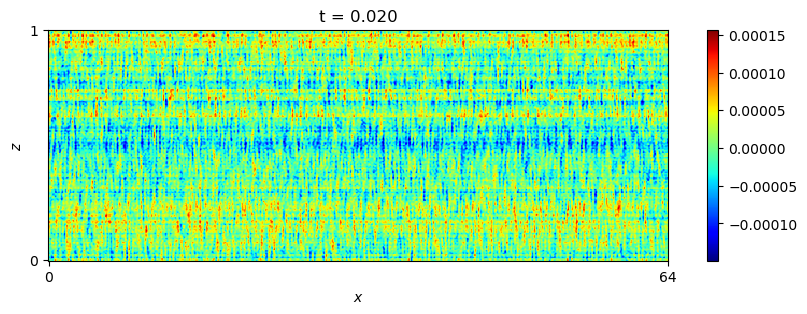

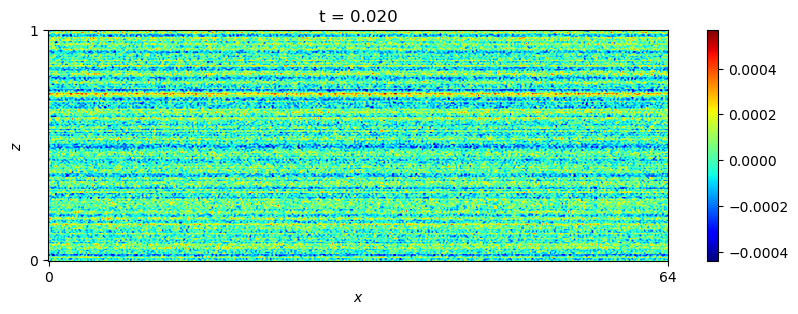

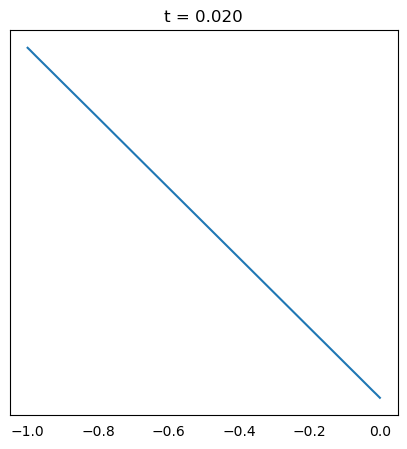

2024-09-24 17:57:04,366 __main__ 0/1 INFO :: Completed iteration 101, time=2.020, dt=0.0200000000


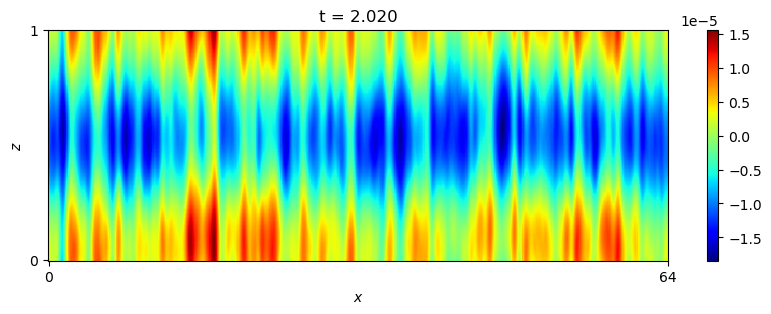

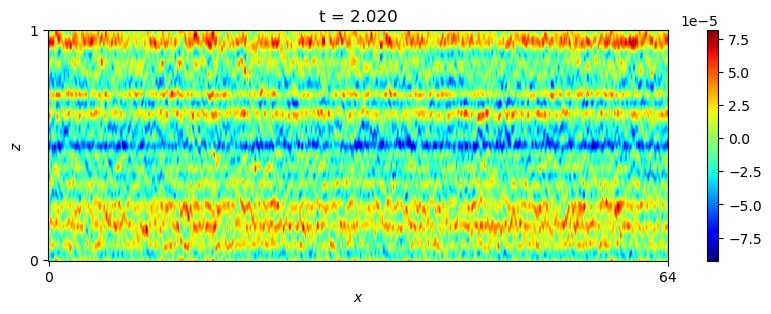

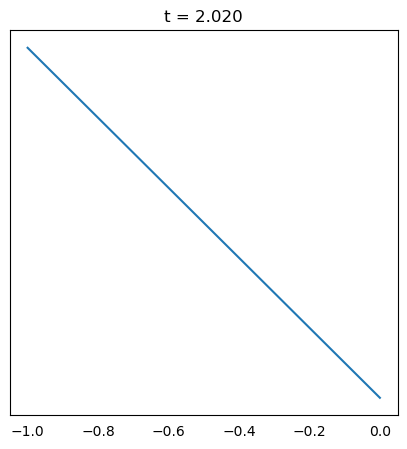

2024-09-24 17:57:16,733 __main__ 0/1 INFO :: Completed iteration 201, time=4.020, dt=0.0200000000


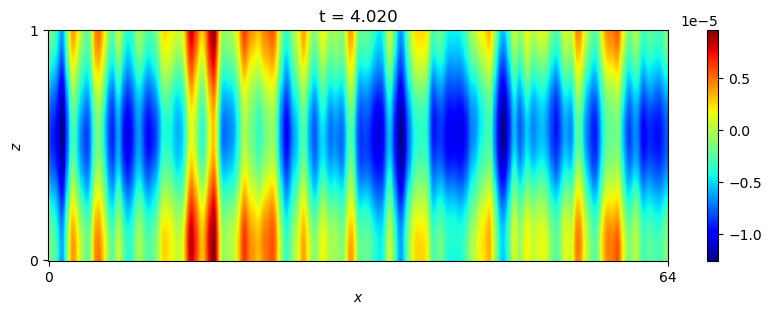

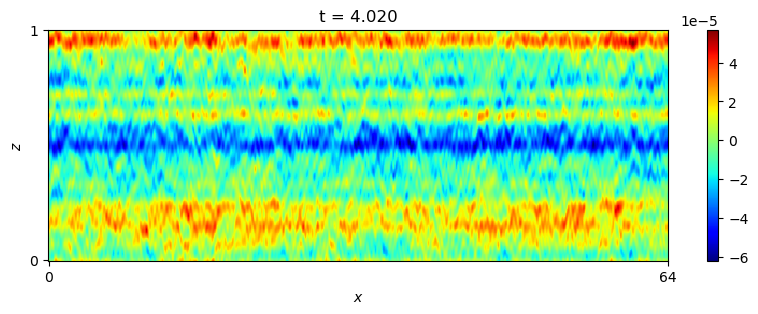

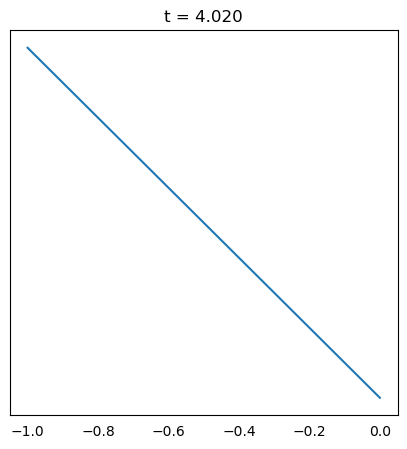

2024-09-24 17:57:29,098 __main__ 0/1 INFO :: Completed iteration 301, time=6.020, dt=0.0200000000


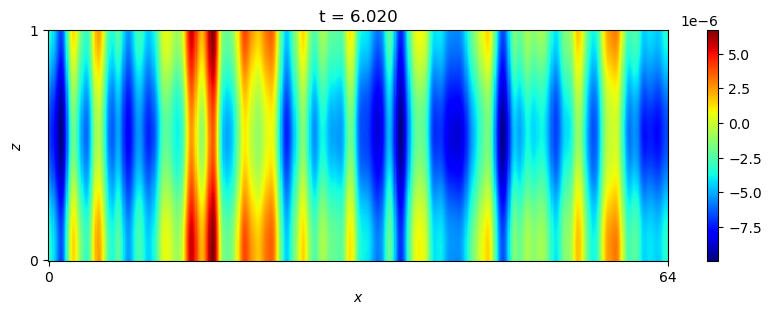

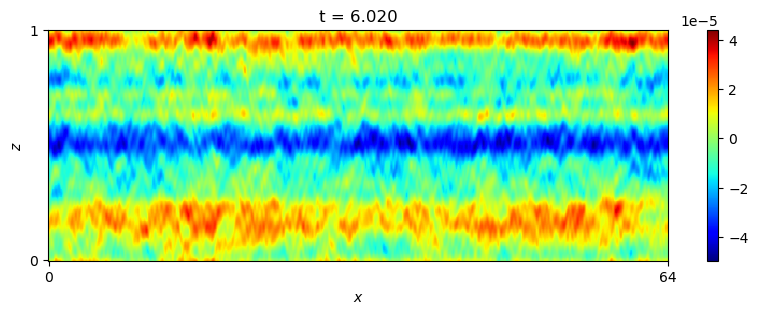

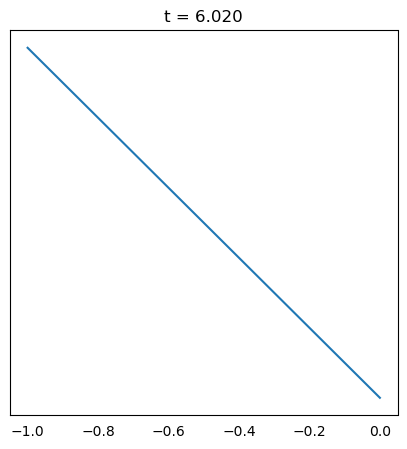

2024-09-24 17:57:41,516 __main__ 0/1 INFO :: Completed iteration 401, time=8.020, dt=0.0200000000


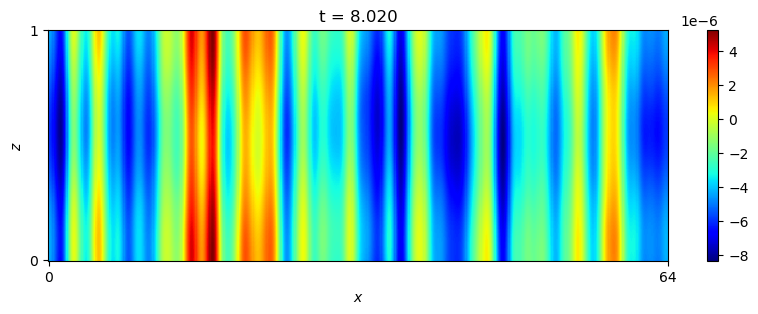

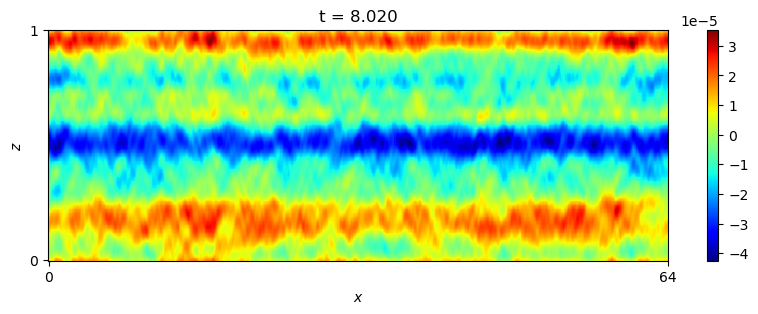

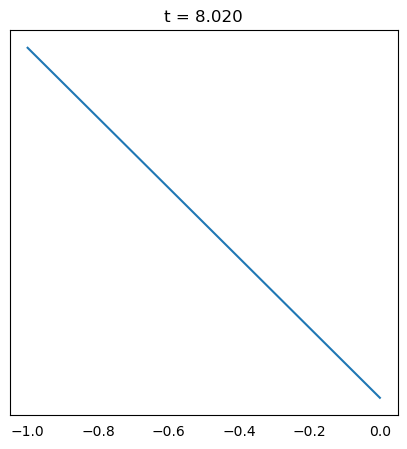

2024-09-24 17:57:53,986 __main__ 0/1 INFO :: Completed iteration 501, time=10.020, dt=0.0200000000


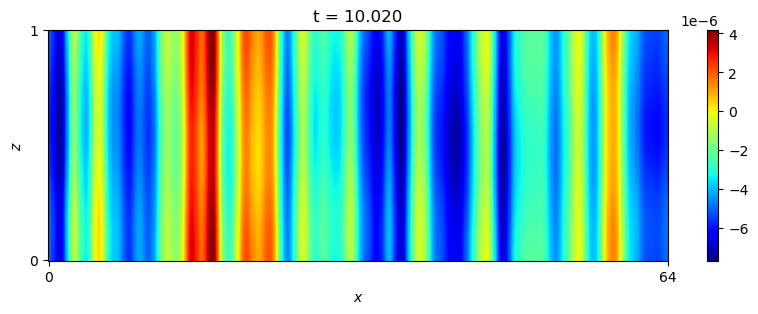

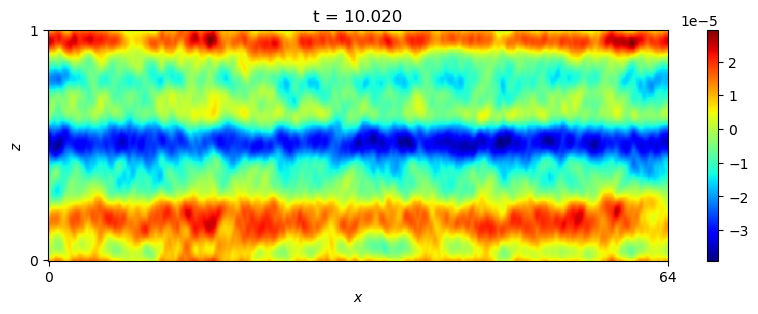

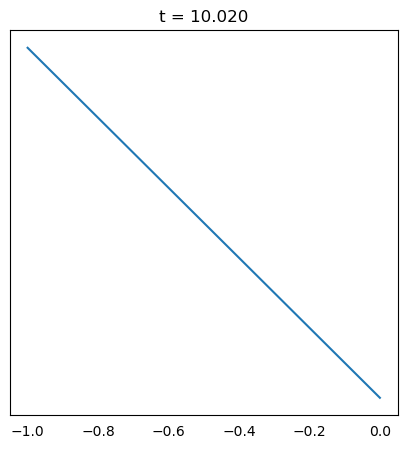

2024-09-24 17:58:06,439 __main__ 0/1 INFO :: Completed iteration 601, time=12.020, dt=0.0200000000


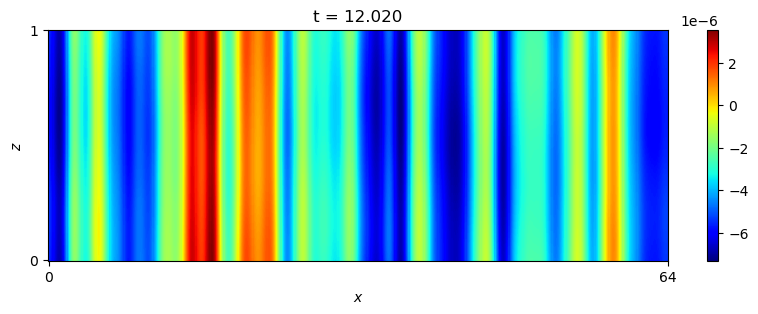

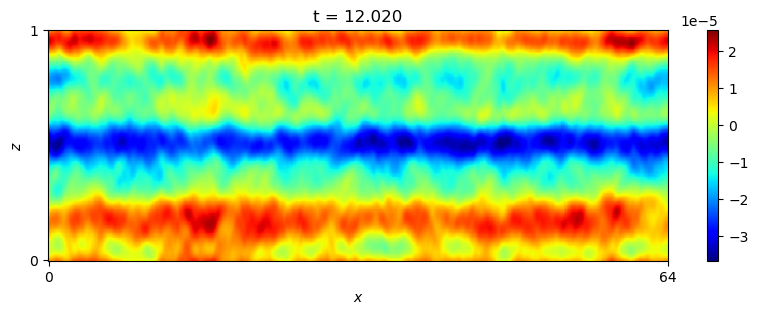

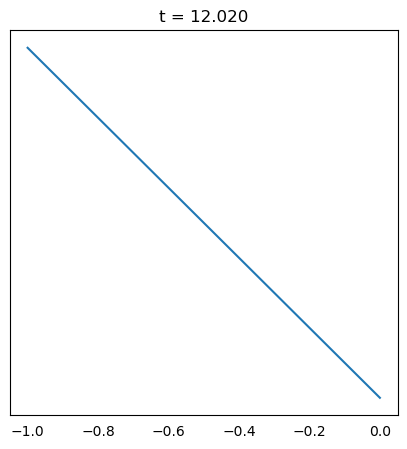

2024-09-24 17:58:18,728 __main__ 0/1 INFO :: Completed iteration 701, time=14.020, dt=0.0200000000


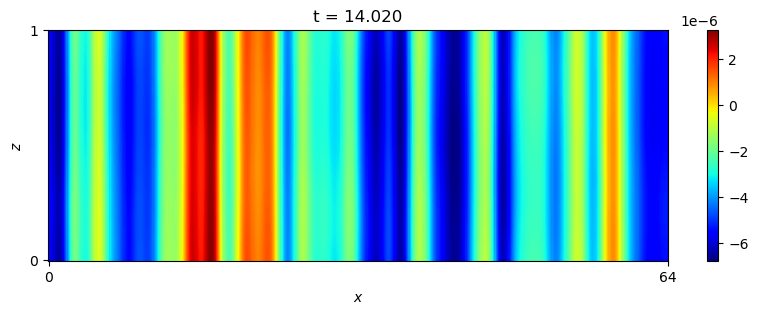

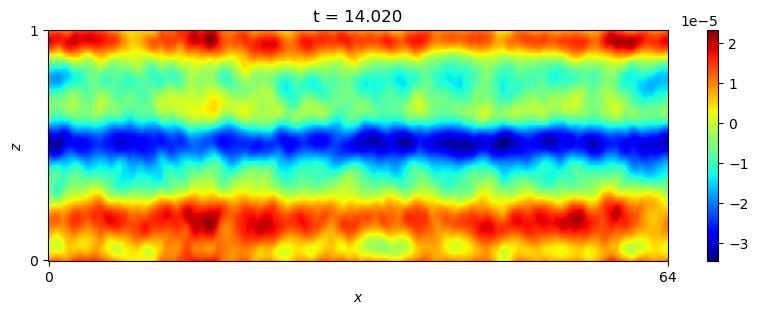

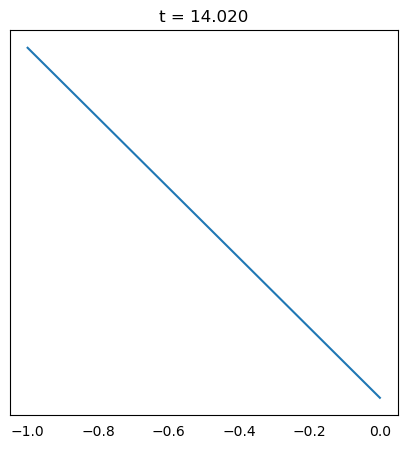

2024-09-24 17:58:31,203 __main__ 0/1 INFO :: Completed iteration 801, time=16.020, dt=0.0200000000


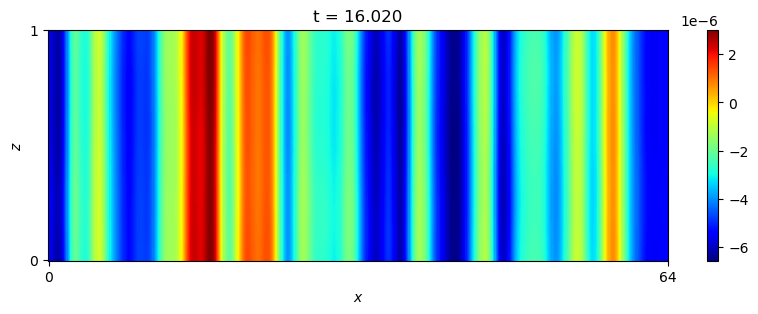

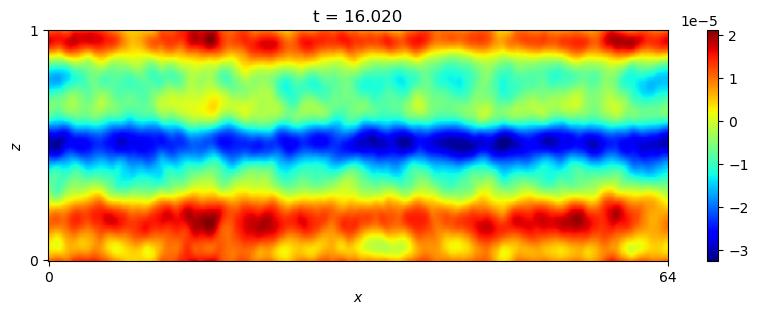

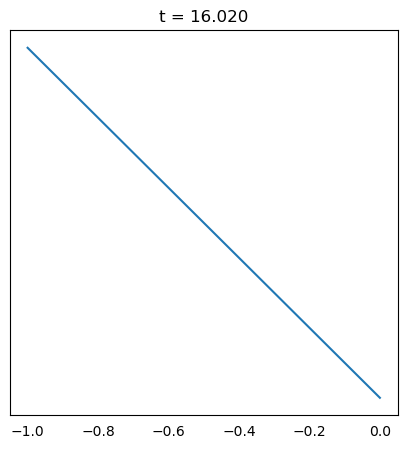

2024-09-24 17:58:44,644 __main__ 0/1 INFO :: Completed iteration 901, time=18.020, dt=0.0200000000


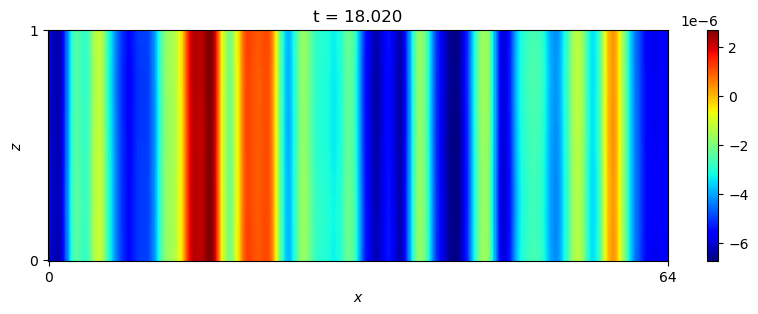

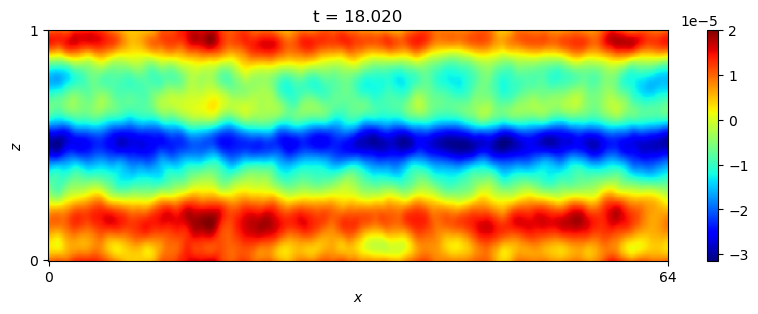

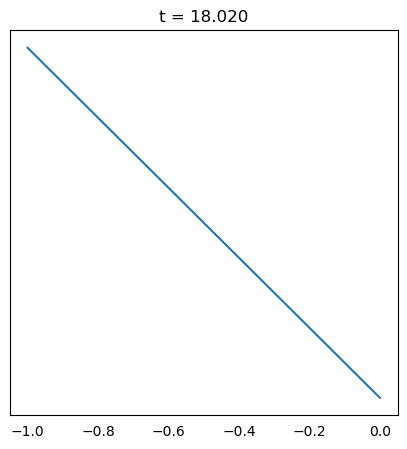

2024-09-24 17:58:58,327 __main__ 0/1 INFO :: Completed iteration 1001, time=20.020, dt=0.0200000000


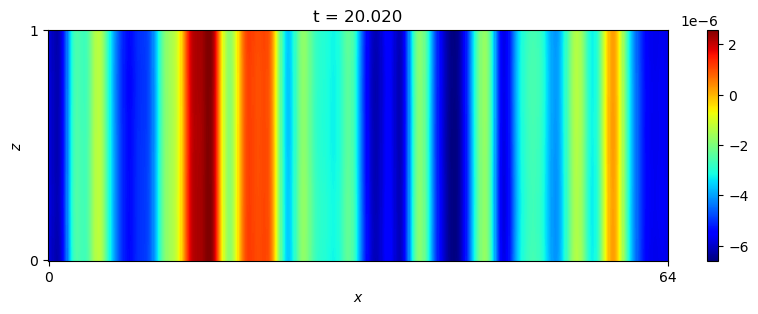

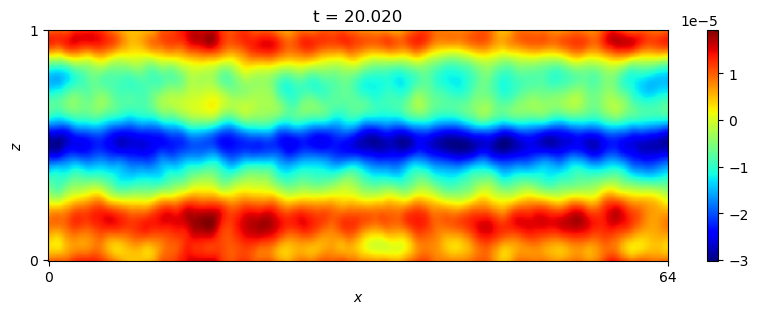

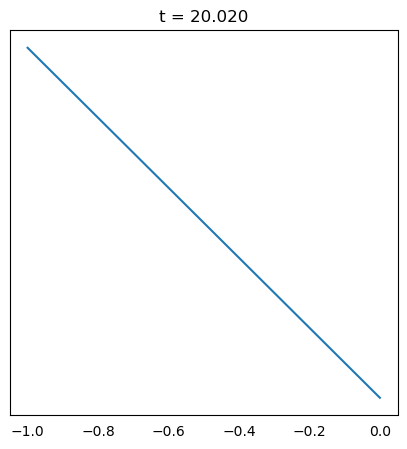

2024-09-24 17:59:11,590 __main__ 0/1 INFO :: Completed iteration 1101, time=22.020, dt=0.0200000000


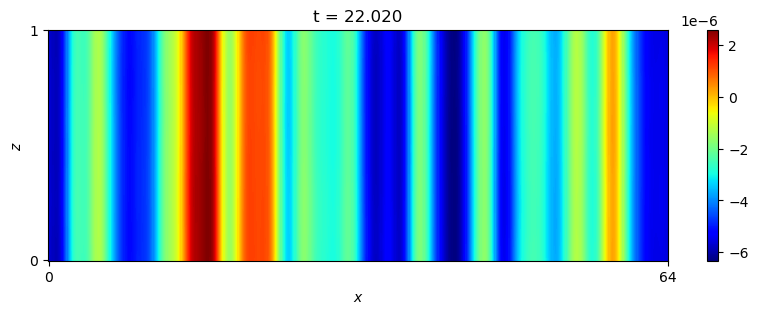

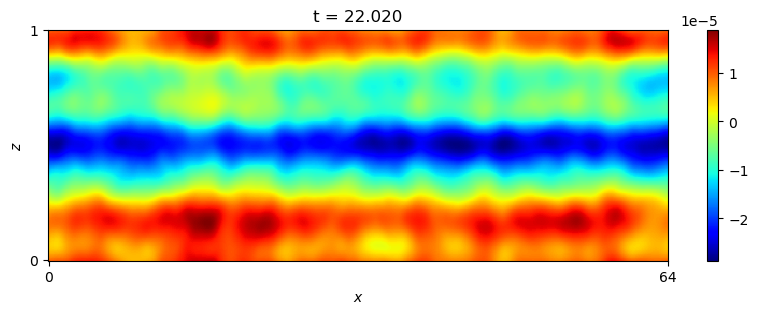

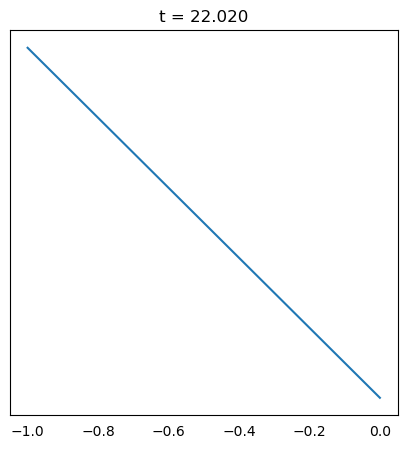

2024-09-24 17:59:24,466 __main__ 0/1 INFO :: Completed iteration 1201, time=24.020, dt=0.0200000000


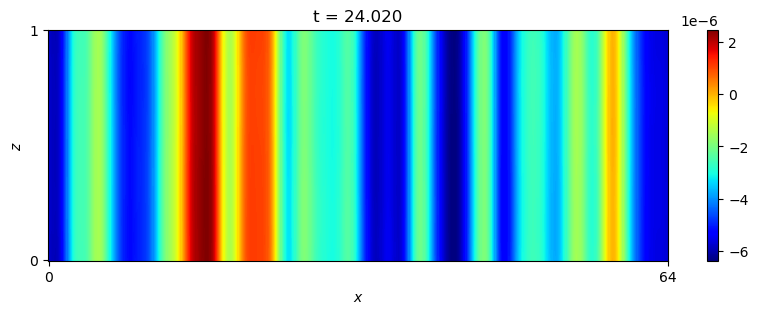

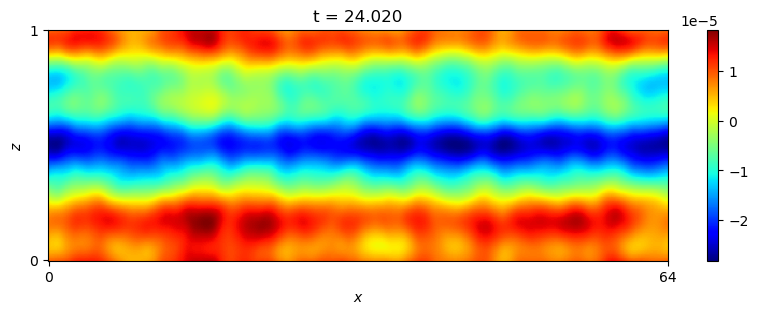

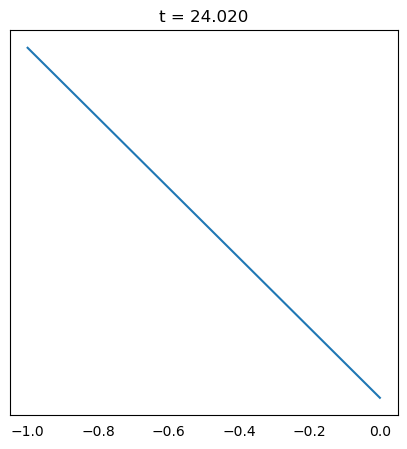

2024-09-24 17:59:37,312 __main__ 0/1 INFO :: Completed iteration 1301, time=26.020, dt=0.0200000000


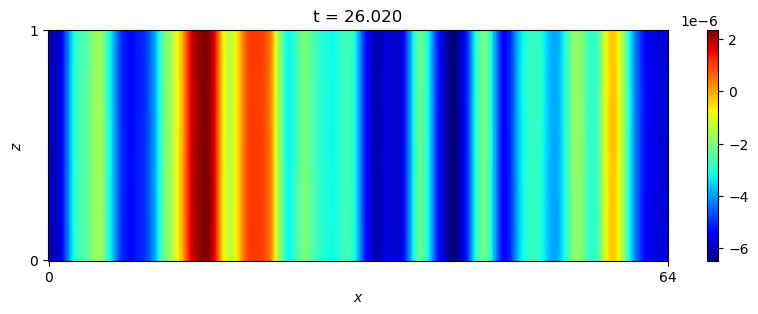

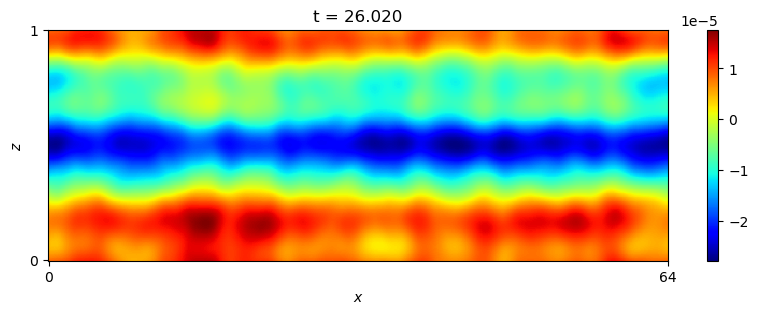

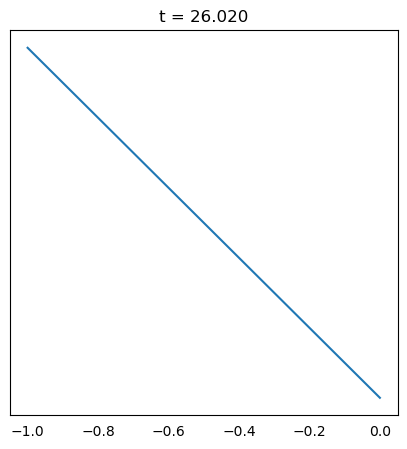

2024-09-24 17:59:50,339 __main__ 0/1 INFO :: Completed iteration 1401, time=28.020, dt=0.0200000000


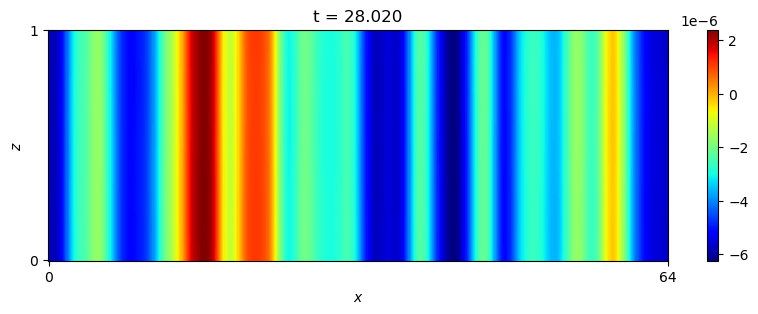

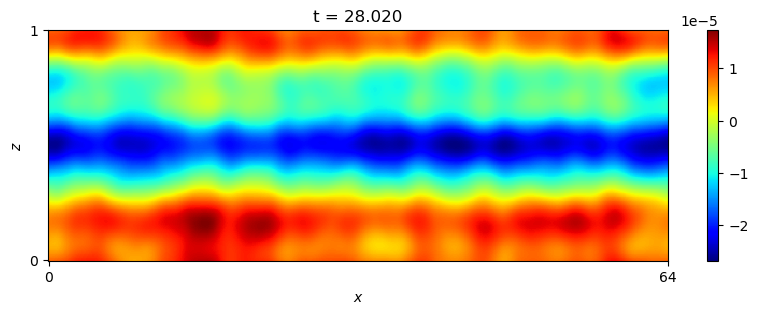

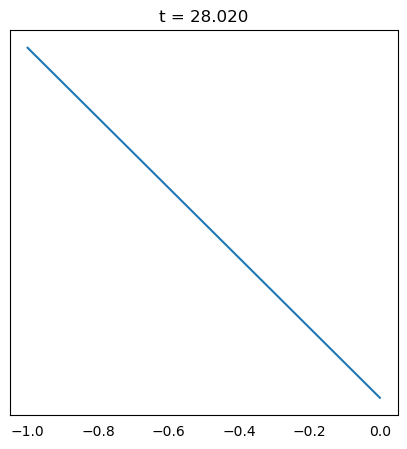

2024-09-24 18:00:00,554 __main__ 0/1 ERROR :: Exception raised, triggering end of main loop.
2024-09-24 18:00:00,554 solvers 0/1 INFO :: Final iteration: 1477
2024-09-24 18:00:00,555 solvers 0/1 INFO :: Final sim time: 29.54585786437573
2024-09-24 18:00:00,555 solvers 0/1 INFO :: Setup time (init - iter 0): 3.686 sec
2024-09-24 18:00:00,555 solvers 0/1 INFO :: Warmup time (iter 0-10): 2.107 sec
2024-09-24 18:00:00,555 solvers 0/1 INFO :: Run time (iter 10-end): 187.4 sec
2024-09-24 18:00:00,555 solvers 0/1 INFO :: CPU time (iter 10-end): 0.05206 cpu-hr
2024-09-24 18:00:00,556 solvers 0/1 INFO :: Speed: 5.741e+06 mode-stages/cpu-sec


KeyboardInterrupt: 

In [226]:
# timestepper = d3.RK443
timestepper = d3.RK222

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
if not restart:
    pm.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    pp.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    um.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    up.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    Tm.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    Tp.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    Sm.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    Sp.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    file_handler_mode = 'overwrite'
    initial_timestep = 0.02
    max_timestep = 0.02
else:
    write, initial_timestep = solver.load_state('/home/jms24002/reproduce_radko_results/fig5/checkpoints/checkpoints_s90.h5')
    max_timestep = 0.02
    file_handler_mode = 'append'
    logger.info('Imported last-step data successfully')

# store data for analysis later
# dataset = solver.evaluator.add_file_handler('snapshots', sim_dt=50.0, max_writes=10000, mode=file_handler_mode)
# dataset.add_task(umx, name='umx')
# dataset.add_task(umz, name='umz')
# dataset.add_task(Tm, name='Tm')
# dataset.add_task(Tp, name='Tp')
# dataset.add_task(Sm, name='Sm')
# dataset.add_task(Sp, name='Sp')
# dataset.add_task(P, name='p')
# dataset.add_task(-d3.div(d3.skew(um+up)), name='vorticity')
# store data to restart later
# checkpoints = solver.evaluator.add_file_handler('checkpoints', sim_dt=100, max_writes=1, mode=file_handler_mode)
# checkpoints.add_tasks(solver.state)

# CFL
CFL = d3.CFL(solver, initial_timestep, cadence=10,
             max_dt=max_timestep,min_dt = 1e-6,
             safety=0.2, threshold=0.1,
             max_change=1.5, min_change=0.5
             )
CFL.add_velocity(U)

xg = xbasis.global_grid(dist, scale=dealias)
zg = zbasis.global_grid(dist, scale=dealias)
# Tmg = Tm.allgather_data('g')

# Main loop
oldtime = 0.
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)  
        if (solver.iteration-1) % 1000 == 0:
            logger.info('Completed iteration {}, time={:.3f}, dt={:.10f}'.format(solver.iteration, solver.sim_time, timestep))        
            ########################### <--- plot instantaneous temperature distribution
            Tg = Tm.allgather_data('g')+Tp.allgather_data('g')
            Sg = Sm.allgather_data('g')+Sp.allgather_data('g')
            if dist.comm.rank == 0:
                # plot temperature distribution
                plt.figure(figsize=(10,3))
                plt.pcolormesh(xg.ravel(),zg.ravel(),Tg.transpose(),cmap='jet')
                plt.colorbar() 
                plt.xticks([0,Lx])
                plt.yticks([0,Lz])
                plt.xlabel(r'$x$')
                plt.ylabel(r'$z$')
                plt.title("t = {:.3f}".format(solver.sim_time))
                plt.show()
                # plt.savefig('snapshots/T_time={:010.3f}.png'.format(solver.sim_time), bbox_inches='tight')
                plt.close()
                # plot temperature distribution
                plt.figure(figsize=(10,3))
                plt.pcolormesh(xg.ravel(),zg.ravel(),Sg.transpose(),cmap='jet')
                plt.colorbar() 
                plt.xticks([0,Lx])
                plt.yticks([0,Lz])
                plt.xlabel(r'$x$')
                plt.ylabel(r'$z$')
                plt.title("t = {:.3f}".format(solver.sim_time))
                plt.show()
                # plt.savefig('snapshots/S_time={:010.3f}.png'.format(solver.sim_time), bbox_inches='tight')
                plt.close()
                # plot horizontaly averaged density profiles
                meanT = np.mean(Tg,axis=0,keepdims=True)
                meanS = np.mean(Sg,axis=0,keepdims=True)
                meanDensity = (meanS-meanT)+(1-Rp)*np.linspace(0,1.,int(Nz*dealias))
                plt.figure(figsize=(5,5))
                plt.plot(np.copy(meanDensity[0]),np.linspace(0,1.,int(Nz*dealias)))
                plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)# Hide xticks
                plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
                plt.title("t = {:.3f}".format(solver.sim_time))
                plt.show()
                # plt.savefig('snapshots/meanDensity_time={:010.3f}.png'.format(solver.sim_time), bbox_inches='tight')
                plt.close()
            ###########################
            if math.isnan(np.max(Tg)):
                logger.error('NaN values')
                break
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()
